# Workflow Debugging

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-04-21 09:42:45.313486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-21 09:42:45.313597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-21 09:42:45.427894: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/18 [>.............................] - ETA: 6s - loss: 61.1888 - accuracy: 0.2812

2022-04-21 09:42:45.634983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 8ms/step - loss: 7.2599 - accuracy: 0.5230
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 1.3569 - accuracy: 0.6259
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 1.0115 - accuracy: 0.6738
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7430 - accuracy: 0.7092
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7680 - accuracy: 0.7730
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6234 - accuracy: 0.7801
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6574 - accuracy: 0.7819
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6522 - accuracy: 0.7908
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6396 - accuracy: 0.7872
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5774 - accuracy: 0.8227
Epoch 11/100
18/18 [=

18/18 [==============================] - 0s 6ms/step - loss: 0.2088 - accuracy: 0.9291
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2550 - accuracy: 0.8936
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2217 - accuracy: 0.9096
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2261 - accuracy: 0.9113
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2212 - accuracy: 0.9113
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2201 - accuracy: 0.9238
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2122 - accuracy: 0.9184
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2093 - accuracy: 0.9184
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1947 - accuracy: 0.9131
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1922 - accuracy: 0.9309
Epoch 93/100


2022-04-21 09:42:56.597669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test data: 0.8842976093292236% 
 Error on test data: 0.11570239067077637
len(y_predicted) 242
wstate_121  predicted:  5  should be:  0  diff:  283.18268677261767
portfoliovqe_16  predicted:  1  should be:  0  diff:  2336.649282111426
graphstate_35  predicted:  0  should be:  5  diff:  1380.038304685525
dj_53  predicted:  5  should be:  0  diff:  613.3003260740315


2022-04-21 09:42:56.814697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


graphstate_24  predicted:  1  should be:  5  diff:  532.2869302878016
ghz_130  predicted:  5  should be:  0  diff:  0
wstate_129  predicted:  5  should be:  0  diff:  0
graphstate_22  predicted:  1  should be:  0  diff:  658.0813899210534
qft_11  predicted:  0  should be:  2  diff:  6862.127032607261
portfoliovqe_15  predicted:  1  should be:  0  diff:  2083.4504204772547
ae_11  predicted:  1  should be:  2  diff:  7124.443787240572
wstate_123  predicted:  5  should be:  0  diff:  635.6271177689223
graphstate_12  predicted:  2  should be:  1  diff:  997826.3558139473
wstate_11  predicted:  5  should be:  2  diff:  724.576597932265
dj_55  predicted:  5  should be:  0  diff:  1037.9159239114515
hhl_5  predicted:  2  should be:  5  diff:  1892.807297438867
portfoliovqe_14  predicted:  1  should be:  0  diff:  3740.309334837075
qpeinexact_19  predicted:  0  should be:  1  diff:  166.60714365360036
vqe_12  predicted:  2  should be:  0  diff:  989024.2123596653
wstate_2  predicted:  0  shoul

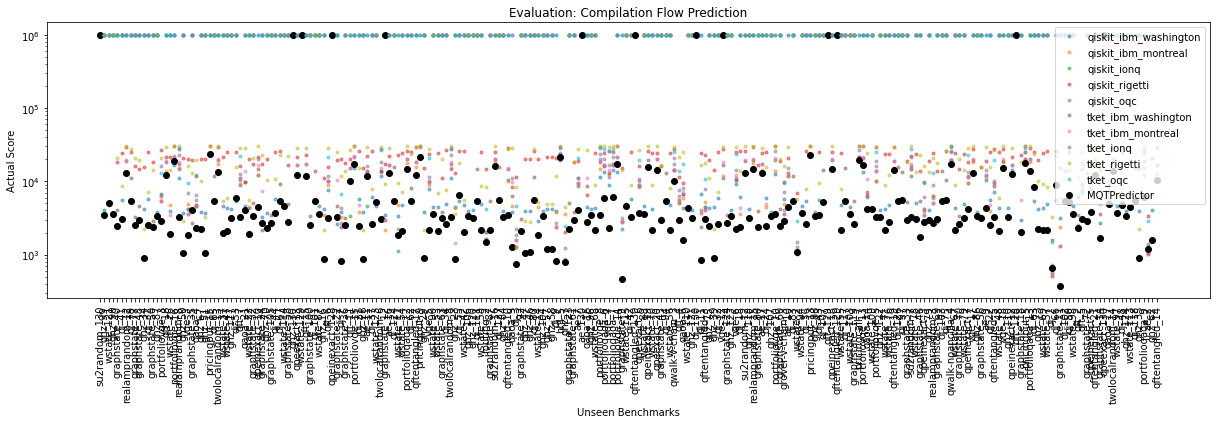

In [1]:
from evaluator.eval import extract_training_data_from_json, train_simple_ml_model
import numpy as np
training_data, names_list, scores_list = extract_training_data_from_json("json_data_big_server.json")
#print(names_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
X = X[:, [ 3,  5, 12, 14, 16, 17, 19, 20, 23, 25, 27, 30 ,37 ,38, 39, 40]]
X.shape
train_simple_ml_model(X,y, True, names_list, scores_list)

In [2]:
from sklearn.model_selection import train_test_split
from evaluator.src import utils
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")


features = np.sort(np.array(res))
features = features[[3,  5, 12, 14, 16, 17, 19, 20, 23, 25, 27, 30 ,37 ,38, 39, 40]]
print(features)


['ccx' 'cp' 'cu1' 'cx' 'cz' 'h' 'num_qubits' 'p' 'rx' 'ry' 'rzz' 'swap'
 'u1' 'u2' 'u3' 'x']


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

#Create a Gaussian Classifier
for i in range(1,10,1):
    clf=RandomForestClassifier(n_estimators=i)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    print(i, np.mean(y_pred == y_test))
    plot_tree(clf.estimators_[0], 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);

NameError: name 'X_train' is not defined

In [10]:
from sklearn.svm import SVC
#Create a Gaussian Classifier

clf=SVC(kernel="linear")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.837037037037037


In [11]:
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5185185185185185


In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier


clf = AdaBoostClassifier(n_estimators=10)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5407407407407407


0.9135338345864662


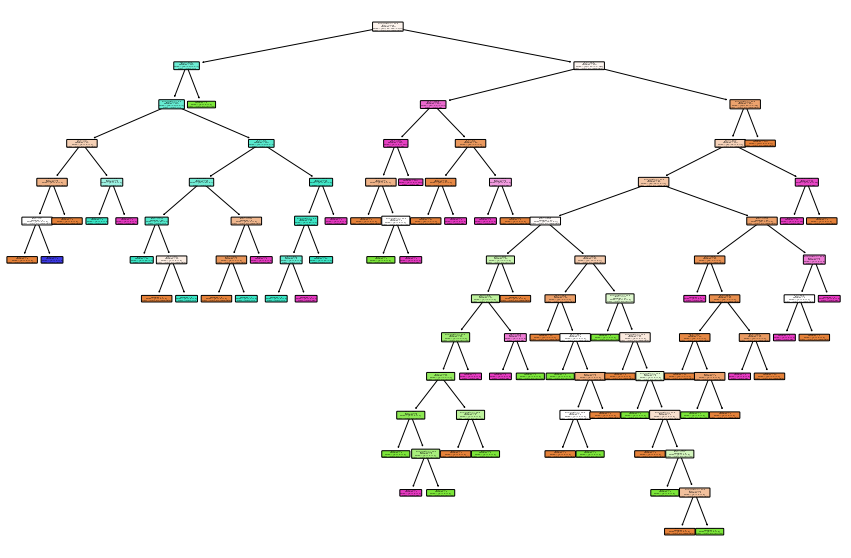

In [3]:

import matplotlib.pyplot as plt
from evaluator.src import utils
from sklearn.tree import plot_tree
from sklearn import tree


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)

fig = plt.figure(figsize=(15, 10))

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))
plot_tree(clf, 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);
plt.savefig("DecisionTreeClassifier.png", dpi=600)

# Debugging

In [1]:
from evaluator import eval
from evaluator.src import utils, pytket_plugin, qiskit_plugin
import pytest
from pytket.extensions.qiskit import qiskit_to_tk
from mqt.bench import get_one_benchmark
from pytket import circuit, OpType

In [64]:
1-4.561e-2




0.95439